<a href="https://colab.research.google.com/github/aldojda/BigData/blob/main/Proyecto_1_Sentiment_Analysis_WebScrapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Sentimiento a comentarios de MisProfesores FCFM

**Objetivo**: Realizar un Ranking de los maestros mejores y peores calificados acompañados de una análisis  de sentimiento para entender la calidad de los comentarios.

Para realizar el siguiente MiniProyecto se requerirá de la libreria de Beaytiful Soup y request las cuales nos permiten consultar información de páginas web (HTML) y realizar busquedas en este tipo de archivos.

El primer paso a realizar es llamar a la página Web Principal (Aquella página web que contiene todos los enlaces para encontrar a los profesores asociados)


In [12]:
import requests
from bs4 import BeautifulSoup
import re
 
 # Making a GET request
r = requests.get('https://www.misprofesores.com/escuelas/UANL-FCFM_2263')
 
# Parsing the HTML
soup = BeautifulSoup(r.content)
soup.title.text

'UANL FCFM - MisProfesores.com'

Enseguida realizamos una busqueda de la tabla en donde se encuentra la información de los Maestros Almacenada con regex

In [13]:
# Find the script tag containing the variable
script_tag = soup.find('script', string=re.compile(r'var dataSet = (.*?);'))

if script_tag:
    # Extract the content between "var dataSet =" and "$"
    match = re.search(r'var dataSet = (.*?)\$',
                      script_tag.text, re.DOTALL)
    if match:
        data = match.group(1)
        print("se encontró la información de los maestros")
    else:
        print("No match found.")
else:
    print("Script tag not found.")

se encontró la información de los maestros


ya con la información de los maestros en diccionarios procedemos a iterar para generar las consultas a cada una de las páginas web

In [14]:
#funciones para reemplazar carácteres para poder realizar la consulta
def replace_latin_chars(s):
    translate_re = re.compile(r'[ÁÉÍÓÚÑÜáéíóúñü]')
    translate = {
        "Á": "A", "É": "E", "Í": "I", "Ó": "O", "Ú": "U", "Ñ": "N", "Ü": "U",
        "á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u", "ñ": "n", "ü": "u"
    }
    return re.sub(translate_re, lambda match: translate[match.group(0)], s)

def fix_url(string):
    nombre = string.strip()
    nombre = replace_latin_chars(nombre)
    nombre = re.sub(r'[^a-zA-Z0-9\s]', '', nombre)
    nombre = nombre.replace("(", "")
    nombre = nombre.replace(")", "")
    nombre = nombre.replace(" -", "-")
    nombre = nombre.replace("- ", "-")
    nombre = nombre.replace("\n", "")
    nombre = nombre.replace("\r", "")
    nombre = nombre.replace("  ", " ")
    nombre = nombre.replace("\\", "")
    nombre = nombre.replace(" ", "-")
    return nombre

def escuela_url(nombre, id):
    return "/escuelas/" + fix_url(nombre) + "_" + id

#función que permite encontrar el url asociado
def profesor_url(dict_):
    nombre = fix_url(dict_["n"])
    apellido = fix_url(dict_["a"])
    return  "https://www.misprofesores.com/profesores/" + nombre + "-" + apellido + "_" + dict_["i"]


#funicones para la consulta y proceso de generación de los datos
def materia(mat): 
    datos = [i.text for i in mat]
    mat = datos[::4]
    obl = datos[1::4]
    calif_al = datos[2::4]
    interes = datos[3::4]
    datos = {"materia": mat,"obligatoria": obl, "calificacion_alumno": calif_al, "interes": interes }
    return datos

def score_tab():
    dates = []
    score1 = []
    score2 = []
    for i in soup.find_all('td', class_ = "rating"):
        date = [j.text  for j in   i.find_all("div", class_ = "date")]
        score = [j.text  for j in   i.find_all("span", class_ = ["score bueno",  "score regular", "score malo"])]
        dates.append(date[0])
        score1.append(score[0])
        score2.append(score[1])
    return dates, score1, score2
#funcion que permite extraer los datos de la url seleccionada
def extraerDatos(url):
    global soup
    df = pd.DataFrame()
    comments = [1]
    #si hay mas paginas iteramos en aquellas que tengan más páginas
    for i in range(1,20):
        if i >1: 
            r = requests.get(url + "?pag=" + str(i))
            if len(comments) == 0 :
                #print("saliendo del ciclo", df.shape)
                return df
        else:
            r = requests.get(url)
        #consultamos información de la página web
        soup = BeautifulSoup(r.content,  "lxml")
        datos = materia(soup.find_all('span', class_='response'))
        dates, score1, score2 = score_tab()
        comments = [i.text.replace('\n', '') for i in soup.find_all('p', class_='commentsParagraph')]
        rating = [i.text for i in soup.find_all('span', class_='rating-type')]
        datos["commentario"] = comments
        datos["calidad_general"] = score1
        datos["facilidad"] = score2
        datos["date"] = dates
        try:
            datos = pd.DataFrame(datos)
            df = pd.concat([df, datos])
        except:
            #print(datos)
            print("error") 

In [15]:
list_dicts = eval(data[:-2].replace("null", "None"))
print("Cantidad de profesores :",  len(list_dicts))
urls = [profesor_url(i) for i in  list_dicts]
print(len(urls))
list_dicts[0]

Cantidad de profesores : 562
562


{'i': '82556',
 'n': 'Azucena Alejandra',
 'a': 'Aceves Alós',
 'd': 'UANL - FCFM (Actuaría)',
 'm': '21',
 'c': '8.6190'}

In [16]:
import requests
from bs4 import BeautifulSoup
from multiprocessing import Pool

# Function to scrape a webpage
def scrape_website(url):
    try: 
        datos = extraerDatos(url)
        print(url[40:60])
        datos["maestro"] = url
        #datos["id"] = dict_["i"]
        print(datos.shape)
        return datos
    except : 
        print("No se pudo descargar la información")

# Number of parallel processes
num_processes = 4

# Create a multiprocessing pool
pool = Pool(processes=num_processes)

# Scrape the URLs in parallel
results = pool.map(scrape_website, urls)

# Close the pool
pool.close()
pool.join()

out = pd.concat(results)
out

/Diana-Castaneda-Rod
(8, 9)
/Sofia-De-la-paz_114
(12, 9)
/Esperanza-Castillo_
(2, 9)
/Azucena-Alejandra-A
(21, 9)
/sandra-angelica-aya
(31, 9)
/Omar-Manuel-Castill
(3, 9)
/Daniel-Raul-Acosta-
(2, 9)
/Sandra-Angelica-Aya
(0, 9)
error
error
error
/Daniel-Arturo-Acuna
(14, 9)
/Janet-Ayala-Santiag
(9, 9)
/Arturo-Castillo-Guz
(5, 9)
error
/Arturo-Alberto-Cast/Ester-Aguayo-Moreno

(2, 9)(0, 9)

error
/Idali-Baltazar_1086
(10, 9)
error
error
/alejandro-barbosa_1
(3, 9)
/TREVINO-CASTILLO-LA
(7, 9)
/Sofia-Herminia-De-L
(55, 9)
/Martin-Aguilar_9678
(17, 9)
/Michelle-Alejandra-
(13, 9)
/Martin-Alejandro-Ag
(3, 9)
/Sofia-Herminia-de-l
(12, 9)
/Selvas-Aguilar-Rome
(11, 9)
error
error
/Abraham-Benito-Barr
(52, 9)
error
/Reyna-Guadalupe-Cas
(26, 9)
/Luz-De-Leon_145326(28, 9)

/Ricardo-Aguirre-Par(0, 9)

/Mikhail-Valentinovi
(6, 9)
/Brenda-Lizbethee-Ca
(7, 9)
error
error
/Francisco-De-Menese
(18, 9)
/Pamela-Bazaldua-Rey
(3, 9)
/Edgar-Alexis-Cerda-
(2, 9)
error
error
/Joel-Antonio-Delgad
(4, 9)
/Carden

,materia,obligatoria,calificacion_alumno,interes,commentario,calidad_general,facilidad,date,maestro
0,Administración del Riesgo Empresarial Aplicada,No obligatoria,10,Bajo,"Realmente no de clase, rep...",9.0,10.0,03/Mar/2022,https://www.misprofesores.com/profesores/Azuce...
1,Contexto Económico Geopolítico,Obligatoria,10,Alto,"Una gran maestra, pase con...",10.0,10.0,05/Ene/2022,https://www.misprofesores.com/profesores/Azuce...
2,Contexto,Obligatoria,10,Alto,Es fácil pasar con ella y ...,6.0,10.0,05/Ene/2022,https://www.misprofesores.com/profesores/Azuce...
3,contexto economico-geopolitico,No obligatoria,10,Bajo,Barcote,6.0,10.0,01/Ene/2022,https://www.misprofesores.com/profesores/Azuce...
4,Estancia de Investigación,No obligatoria,10,Medio,,7.0,10.0,26/Nov/2021,https://www.misprofesores.com/profesores/Azuce...
...,...,...,...,...,...,...,...,...,...
1,Modelado orgánico,No obligatoria,24,Alto,,10.0,10.0,13/Dic/2020,https://www.misprofesores.com/profesores/Raymu...
2,Modelado Orgánico,No obligatoria,8.5,Alto,"Muy buen profesor, siempre...",10.0,4.0,13/Dic/2020,https://www.misprofesores.com/profesores/Raymu...
3,Modelado Organico,Obligatoria,9.5,Alto,"Es buen profe, sabe mucho ...",9.0,8.0,05/Ago/2020,https://www.misprofesores.com/profesores/Raymu...
4,Modelado Órganico,No obligatoria,9,Alto,Enseña bien pero las prime...,8.0,6.0,10/Jun/2020,https://www.misprofesores.com/profesores/Raymu...


ya con las funciones declaradas para la limpieza y transformación de URL's, procedemos a generar las consultas a cáda una de las URl's.

Dependiendo la cantidad de comentarios que tenga un maestro es la cantidad de consultas, así que esta parte del proceso toma tiempo.

In [17]:
"""
import pandas as pd
out = pd.DataFrame()
for dict_ in urls[:2]:
    print("Extrayendo Información de : ", dict_)
    try: 
        url_prof = profesor_url(dict_)
        datos = extraerDatos(dict_)
        datos["maestro"] = dict_#dict_["n"] +" "+ dict_["a"]
        #datos["id"] = dict_["i"]
        out = pd.concat([out, datos])
        print(out.shape)
    except : 
        print("No se pudo descargar la información")
"""

'\nimport pandas as pd\nout = pd.DataFrame()\nfor dict_ in urls[:2]:\n    print("Extrayendo Información de : ", dict_)\n    try: \n        url_prof = profesor_url(dict_)\n        datos = extraerDatos(dict_)\n        datos["maestro"] = dict_#dict_["n"] +" "+ dict_["a"]\n        #datos["id"] = dict_["i"]\n        out = pd.concat([out, datos])\n        print(out.shape)\n    except : \n        print("No se pudo descargar la información")\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
out.to_csv("drive/MyDrive/01 - Maestría Ciencia de Datos/Datos Masivos/datos_FCFM_misprofesores.csv")

In [19]:
#import pandas as pd
#out = pd.read_csv("drive/MyDrive/01 - Maestría Ciencia de Datos/Datos Masivos/datos_FCFM_misprofesores.csv")

In [20]:
def clean_text(text):
    # Remove special characters and symbols
    cleaned_text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    
    # Remove extra whitespaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    
    # Remove leading and trailing spaces
    cleaned_text = cleaned_text.strip()
    
    # Convert to lowercase
    cleaned_text = cleaned_text.lower()
    
    return cleaned_text

out['clean_comments'] = out.commentario.apply(lambda x: clean_text(x))
df = out.dropna(subset = ["clean_comments"])
df = df[df.clean_comments != "" ]
df.head()

,materia,obligatoria,calificacion_alumno,interes,commentario,calidad_general,facilidad,date,maestro,clean_comments
0,Administración del Riesgo Empresarial Aplicada,No obligatoria,10,Bajo,"Realmente no de clase, rep...",9.0,10.0,03/Mar/2022,https://www.misprofesores.com/profesores/Azuce...,realmente no de clase reparte los temas entre ...
1,Contexto Económico Geopolítico,Obligatoria,10,Alto,"Una gran maestra, pase con...",10.0,10.0,05/Ene/2022,https://www.misprofesores.com/profesores/Azuce...,una gran maestra pase con 10 solo es cuestin d...
2,Contexto,Obligatoria,10,Alto,Es fácil pasar con ella y ...,6.0,10.0,05/Ene/2022,https://www.misprofesores.com/profesores/Azuce...,es fcil pasar con ella y aprender mucho pero e...
3,contexto economico-geopolitico,No obligatoria,10,Bajo,Barcote,6.0,10.0,01/Ene/2022,https://www.misprofesores.com/profesores/Azuce...,barcote
0,Contexto Económico Geopolítico,Obligatoria,10,Alto,El semestre fue de present...,8.0,8.0,25/Nov/2021,https://www.misprofesores.com/profesores/Azuce...,el semestre fue de presentaciones en equipo el...


In [ ]:
pip install transformers

In [ ]:
pip install xformers

In [34]:
import torch
from transformers import pipeline

# List of texts to process
texts = df.clean_comments.to_list()
nlp = pipeline("sentiment-analysis",
               model="finiteautomata/beto-sentiment-analysis", 
               tokenizer="finiteautomata/beto-sentiment-analysis")

def analyze_sentiment(comments):
    batch_size = 16  # Adjust the batch size as per your needs
    sentiment_scores = []
    for i in range(0, len(comments), batch_size):
        batch = comments[i:i+batch_size]
        batch_sentiments = nlp(batch)
        sentiment_scores.extend(batch_sentiments)
    return sentiment_scores

# Process the results
sentiment_results = analyze_sentiment(texts)

Se clasificarón  mas de3500 comentarios para poder entender el sentimiento de los clientes con un modelo tipo Transformers se utilizó procesamiento en paralelo para poder realizar este calculo de una mejor manera.

In [36]:
df['sentiment'] = [result['label'] for result in sentiment_results]
df['confidence'] = [result['score'] for result in sentiment_results]

In [171]:
#df.drop(columns = "commentario").to_csv("drive/MyDrive/01 - Maestría Ciencia de Datos/Datos Masivos/datos_FCFM_misprofesores_clasificado.csv")
df= pd.read_csv("drive/MyDrive/01 - Maestría Ciencia de Datos/Datos Masivos/datos_FCFM_misprofesores_clasificado.csv")
df[df.calificacion_alumno <=10]
df.head(1)

,Unnamed: 0,materia,obligatoria,calificacion_alumno,interes,calidad_general,facilidad,date,maestro,clean_comments,sentiment,confidence,profesor,day,month,year
0,0,administracin del riesgo empresarial aplicada,No obligatoria,10.0,Bajo,9.0,10.0,2022-03-01,https://www.misprofesores.com/profesores/Azuce...,realmente no de clase reparte los temas entre ...,NEU,0.992823,azucena alejandra aceves alos,1,3,2022


## Analisis de Resultados


In [172]:
df["profesor"] = df.maestro.str.split("/").apply(\
    lambda x: x[4]).str.split("_").apply(lambda x: x[0]).str.replace("-", " ")
df["profesor"] = df["profesor"].apply(lambda x: clean_text(x))
#df["materia"] = df["materia"].apply(lambda x: clean_text(x))
df["day"] = "01" #df.date.str.split("/").apply(lambda x: x[0]).str[1:]
#df["month"] = df.date.str.split("/").apply(lambda x: x[1]).str.lower().replace(date2map)
#df["year"] = df.date.str.split("/").apply(lambda x: x[2])
#df["date"] = pd.to_datetime(df.year + "/" + df.month + "/" + df.day, format = "%Y/%m/%d")


In [173]:
date2map = {'mar': "03",
            'ene': "01", 
            'nov': "11", 
            'jun': "06", 
            'dic': "12",
            'ago': "08", 
            'may': "06",
            'jul': "07", 
            'oct': "10",
            'abr': "04",
            'sep': "09",
            'feb': "02"}

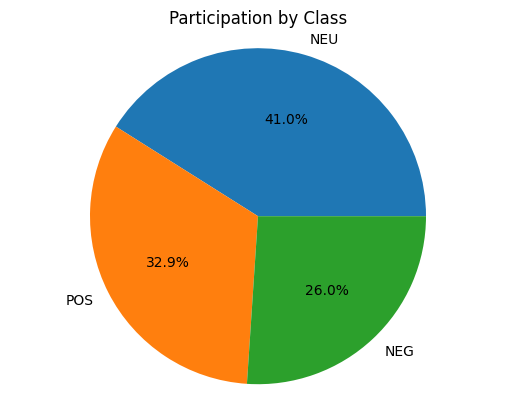

In [174]:
import matplotlib.pyplot as plt
class_counts = df['sentiment'].value_counts()
class_percentages = (class_counts / class_counts.sum()) * 100

labels = class_counts.index
counts = class_counts.values

fig, ax = plt.subplots()
wedges, _, autotexts = ax.pie(counts, labels=labels, autopct='%1.1f%%')

ax.axis('equal')

# Add drilldown functionality
def on_click(event):
    wedge = event.artist
    index = wedges.index(wedge)
    selected_class = labels[index]

    names = df[df['sentiment'] == selected_class]['profesor']
    name_counts = names.value_counts()
    name_percentages = (name_counts / name_counts.sum()) * 100

    plt.clf()
    plt.pie(name_counts, labels=name_counts.index, autopct='%1.1f%%')
    plt.title(f"Participants in Class {selected_class}")

    plt.show()

plt.title("Participation by Class")
plt.show()

cómo podemos observar, los comentarios que más dominan para los profesores son los neutrales (es de esperarse), en segundo lugar son los positivos y en tercer lugar aquellos negativos.

Enseguida tenemos un ranking de sentimiento de porcentaje de comentarios negativos para aquellos maestros que tienen más de 10 comentarios

<Axes: ylabel='profesor'>

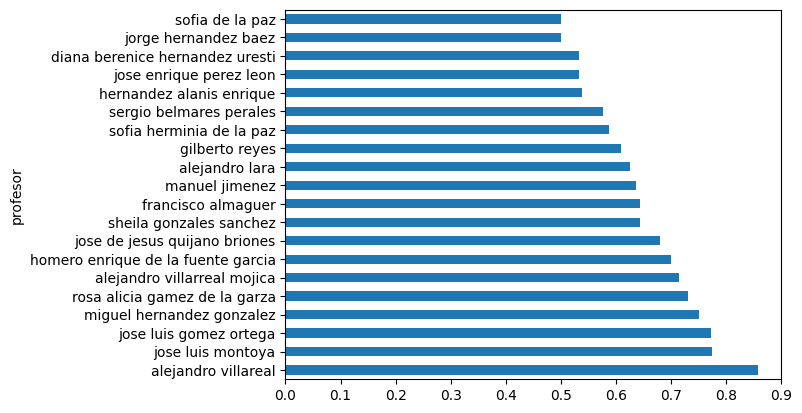

In [175]:
tab = df.groupby("profesor").sentiment.value_counts("normalize").unstack(-1).fillna(0)
tab["comentarios"] = tab.index.map(df.groupby("profesor").sentiment.count().to_dict())
tab[tab.comentarios>10].sort_values(by = "NEG", ascending = False).head(20).NEG.plot(kind = "barh")

<Axes: ylabel='materia'>

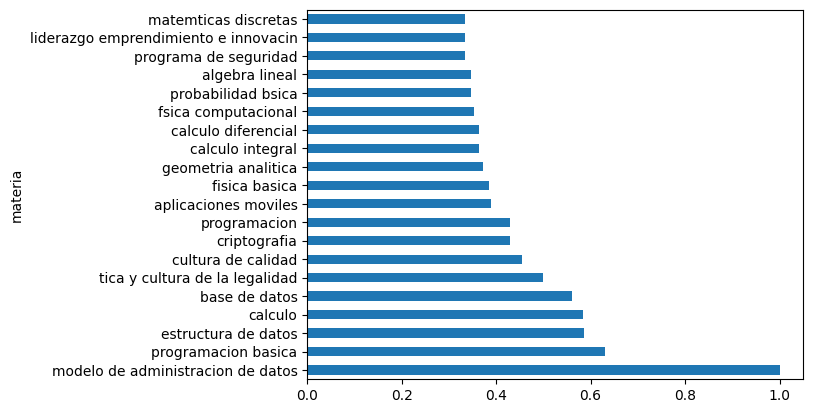

In [176]:
tab = df.groupby("materia").sentiment.value_counts("normalize").unstack(-1).fillna(0)
tab["comentarios"] = tab.index.map(df.groupby("materia").sentiment.count().to_dict())
tab[tab.comentarios>10].sort_values(by = "NEG", ascending = False).head(20).NEG.plot(kind = "barh")

In [178]:
tab = df.groupby(["materia", "profesor"]).sentiment.value_counts().unstack(-1).fillna(0)
tab.index = [i[0] + "_" + i[1] for i in tab.index]

tab2 = df.groupby(["materia", "profesor"]).agg({ i : "mean" for i in  ["calidad_general", "facilidad", "calificacion_alumno"]})
tab2.index = [i[0] + "_" + i[1] for i in tab2.index]

tab = pd.merge(tab, tab2, left_index=True, right_index=True)

#tab["comentarios"] = tab.index.map(df.groupby("materia").sentiment.count().to_dict())
#tab[tab.comentarios>10].sort_values(by = "NEG", ascending = False).head(20).NEG.plot(kind = "barh")
tab["comentarios"] = tab["NEG"] +  tab["POS"] +  tab["NEU"]
tab["neg_pp"] = tab["NEG"] /tab["comentarios"] 

<Axes: xlabel='calidad_general', ylabel='neg_pp'>

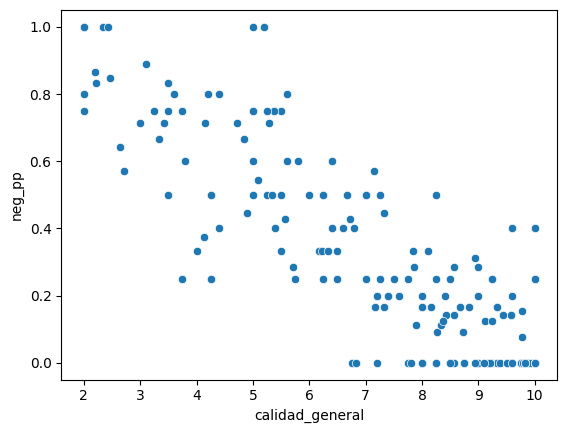

In [179]:
import seaborn as sns
sns.scatterplot(tab[tab.comentarios > 3], x = "calidad_general", y = "neg_pp")

<Axes: xlabel='facilidad', ylabel='neg_pp'>

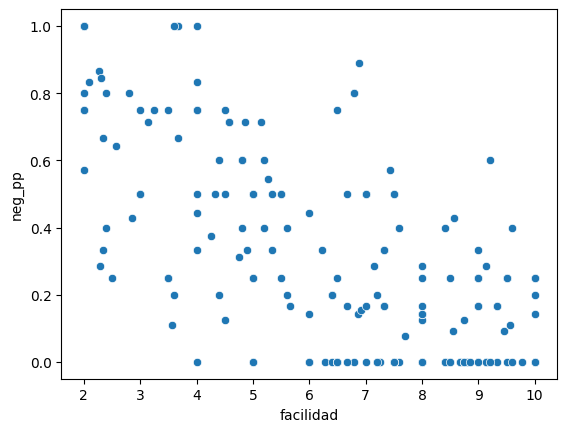

In [180]:
import seaborn as sns
sns.scatterplot(tab[tab.comentarios > 3], x = "facilidad", y = "neg_pp")

<Axes: xlabel='calificacion_alumno', ylabel='neg_pp'>

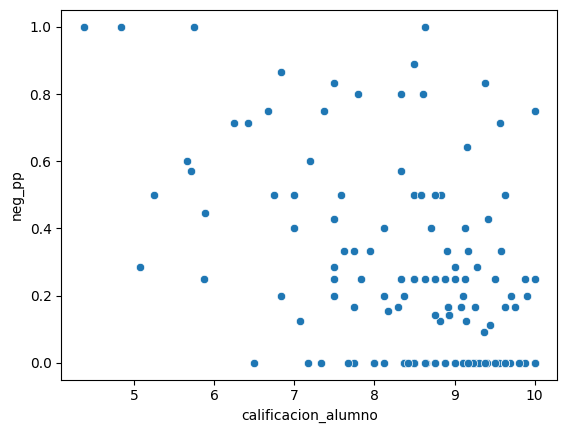

In [185]:
sns.scatterplot(tab[(tab.comentarios > 3) & (tab.calificacion_alumno <=10) ], x = "calificacion_alumno", y = "neg_pp")

<Axes: >

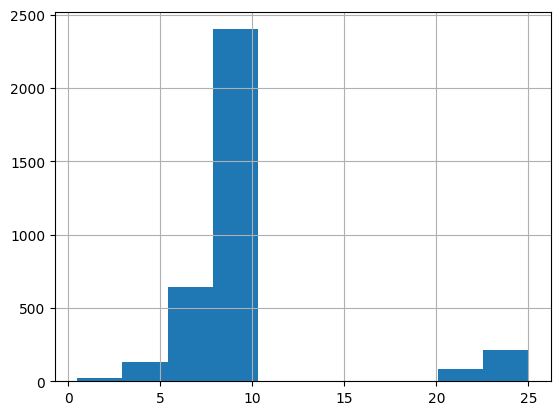

In [183]:
df.calificacion_alumno.hist()